# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 2: Discrete-Event Simulation** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

## <font color = LightBlue> **Exercise 1** </font>

#### <font color = Grey> ***MATHEMATICAL EXPLANATION*** </font>
Queing theory is applicable to many real-world scenario's. By looking at $\textit{performance measures}$, such as mean waiting time and the mean number of customers in a system, we can derive some characteristics about the system. We will be looking at the mean waiting time of two different types of queing, namely M/M/1 and M/M/c, with a closer look at M/M/2. Hence we will compare queing with one server and 2 servers respectively. In order to evaluate the mean waiting time for these two types, we need to establish some parameters:

- $E(S)$ = Mean sojourn time (waiting in queue + service time)
- $E(L)$ = Mean number of customers in the system
- $\lambda$ = Rate of arrivals
- $\mu$ = Rate of service
- $\rho$ = $\frac{\lambda}{\mu}$ (server utilization/load)
- $E(L)$ = $\lambda$ $\cdot$ $E(S)$ (Little's Law)

##### <font color = Green> ***M/M/1*** </font>
In a M/M/1 system the mean number of customers in the systems is defined as: </br>

$ E(L) = \sum_{n=0}^{\infty} n \cdot p_n = \frac{\rho}{1- \rho} $

This can be rewritten as:</br>
$ E(L) = \frac{\lambda}{\mu- \lambda} $

$ E(L)$ cannot be negative as we cannot have negative queues, therefore the condition $\lambda<\mu$ holds. This gives $\rho=\frac{\lambda}{\rho}<1$

In order to find the mean number of customers in the queue $(E(L^q))$, the mean number of customers in service need to substracted from $E(L)$: </br>
$ E(L^q) = E(L) - \rho = \frac{\rho^2}{1- \rho} $. 

Finally, by applying Little's Law, we obtain the mean waiting time: </br>
$E(W) = \frac{\rho}{\mu} \cdot \frac{1}{1-\rho}$

##### <font color = Green> ***M/M/c*** </font>
The mean number of customers in the queue is given by: </br>
$ E(L^q) = \sum_{n=0}^{\infty} n \cdot p_{c+n} $ </br>
$        = \frac{p_c}{1 - \rho} \cdot \sum_{n=0}^{\infty} n \cdot (1- \rho) \cdot \rho^n $ </br>
$        = \pi_W \cdot \frac{\rho}{1 - \rho} $

By applying Little's Law, we obtain the mean waiting time: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \cdot \mu} $,
in case of two servers, this would yield in: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \cdot \mu} $


#### <font color = Grey> ***THEORETICAL EXPLANATION***</font>
In a queuing system where multiple servers are available (M/M/n), each server shares the task of handling incoming customers, as opposed to all customers lining up for a single server (M/M/1). This setup reduces the effective arrival rate of customers to each server because they are distributed across several servers. As a result, customers are likely to wait less because there is a higher chance that one of the servers will be free to help them sooner. Therefore, the system can manage more customer arrivals. This efficiency becomes especially significant when the system is close to its maximum capacity, denoted by a utilization value ($\rho$) near 1. At this point, the presence of multiple servers is more important, as they collectively handle the high volume of customers and keep wait times shorter than what a single server could achieve.

When $\rho$ is significantly less than one, the system is underutilized. There is ample service capacity to handle the arriving customers, so customers rarely have to wait, and the queue is often empty or very short. This does not provide much insight into the behavior of the queue under stress. However, when $\rho$ is close to one, without exceeding it, the system is operating near its maximum capacity. This scenario is much more interesting because it tests the limits of the ability of the system to handle utilisation. Small fluctuations in arrival or service rates can cause significant changes in wait times and queue lengths.

## <font color = LightBlue> **Exercise 2** </font>

In [1]:
import simpy
import random
import statistics
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Parameters
RANDOM_SEED = 42
SIM_TIME = 300
MU = 10
NUM_SERVERS = [1, 2, 4]
RHO_VALUES = np.linspace(0.92, 0.99, 8)
NUM_RUNS = 15

random.seed(RANDOM_SEED)

# Service time functions
def get_service_time(service_type):
    if service_type == "M":
        return random.expovariate(MU)
    elif service_type == "D":
        return 1 / MU  # Deterministic service time
    elif service_type == "H":
        return hyperexponential_service_time()
    else:
        raise ValueError("Invalid service type")

# Function for hyperexponential function (long-tail?)
def hyperexponential_service_time():
    distribution_choice = random.choices([1.0, 5.0], weights=[0.75, 0.25])[0]
    rate = 1.0 / distribution_choice
    return random.expovariate(rate)

# Customer process
def customer(env, servers, wait_times_list, sojourn_times_list, service_type):
    arrival_time = env.now
    with servers.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times_list.append(wait_time)
        service_time = get_service_time(service_type)
        yield env.timeout(service_time)
        sojourn_time = env.now - arrival_time
        sojourn_times_list.append(sojourn_time)

# Source process
def source(env, num_servers, rho, servers, wait_times_list, sojourn_times_list, service_type):
    arrival_rate = rho * num_servers * MU
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, servers, wait_times_list, sojourn_times_list, service_type))

# Simulation setup
def run_simulation(num_servers, rho, wait_times, sojourn_times, priority, service_type):
    env = simpy.Environment()
    servers = simpy.PriorityResource(env, capacity=num_servers) if priority else simpy.Resource(env, capacity=num_servers)
    wait_times_list = wait_times[num_servers][rho]
    sojourn_times_list = sojourn_times[num_servers][rho]
    env.process(source(env, num_servers, rho, servers, wait_times_list, sojourn_times_list, service_type))
    env.run(until=SIM_TIME)

# Data aggregation and analysis
def aggregate_data(times_list):
    mean_time = statistics.mean(times_list)
    stdev_time = statistics.stdev(times_list)
    ci_low, ci_upp = scipy.stats.t.interval(0.95, len(times_list)-1, loc=mean_time, scale=stdev_time/np.sqrt(len(times_list)))
    return mean_time, ci_low, ci_upp

# Main simulation function
def main(num_servers, rho_values, priority, service_type):
    results = []
    wait_times = {n: {rho: [] for rho in rho_values} for n in num_servers}
    sojourn_times = {n: {rho: [] for rho in rho_values} for n in num_servers}
    for n_servers in num_servers:
        for rho in rho_values:
            aggregated_wait_times = []
            aggregated_sojourn_times = []
            for _ in range(NUM_RUNS):
                wait_times[n_servers][rho] = []
                sojourn_times[n_servers][rho] = []
                run_simulation(n_servers, rho, wait_times, sojourn_times, priority, service_type)
                aggregated_wait_times.extend(wait_times[n_servers][rho])
                aggregated_sojourn_times.extend(sojourn_times[n_servers][rho])
            mean_wait, ci_low_wait, ci_upp_wait = aggregate_data(aggregated_wait_times)
            mean_sojourn, ci_low_sojourn, ci_upp_sojourn = aggregate_data(aggregated_sojourn_times)
            results.append((n_servers, rho, mean_wait, ci_low_wait, ci_upp_wait, mean_sojourn, ci_low_sojourn, ci_upp_sojourn))
            print(f'Number of servers: {n_servers}, ρ: {rho}, Mean wait time: {mean_wait:.2f}, 95% CI: ({ci_low_wait:.2f}, {ci_upp_wait:.2f}), Mean sojourn time: {mean_sojourn:.2f}, 95% CI: ({ci_low_sojourn:.2f}, {ci_upp_sojourn:.2f})')
    return results

def plot_results(list_results, title, list_labels, sojourn_time=False):
    plt.figure(figsize=(10, 6))
    colors = list(mcolors.TABLEAU_COLORS)
    line_styles = ['-', '--', ':']  # Different line styles for different queue systems, add more if you want to compare more
    
    # Dictionary to map the number of servers to a color
    color_map = {}
    current_color_index = 0

    for i, (results, label) in enumerate(zip(list_results, list_labels)):
        plot_data = {n: [] for n, _, _, _, _, _, _, _ in results}
        for num_server, rho, mean_wait, ci_lower_wait, ci_upper_wait, mean_sojourn, ci_lower_sojourn, ci_upper_sojourn in results:
            plot_data[num_server].append((rho, mean_wait, ci_lower_wait, ci_upper_wait, mean_sojourn, ci_lower_sojourn, ci_upper_sojourn))
        
        for num_server in plot_data:
            if num_server not in color_map:
                color_map[num_server] = colors[current_color_index % len(colors)]
                current_color_index += 1

            server_results = plot_data[num_server]
            rhos, mean_waits, ci_lowers_wait, ci_uppers_wait, mean_sojourns, ci_lowers_sojourn, ci_uppers_sojourn = zip(*server_results)
            color = color_map[num_server]
            line_style = line_styles[i]  # Use the index in list_labels to determine line style
            
            lower_error = [mean - ci_lower for mean, ci_lower in zip((mean_sojourns if sojourn_time else mean_waits), (ci_lowers_sojourn if sojourn_time else ci_lowers_wait))]
            upper_error = [ci_upper - mean for mean, ci_upper in zip((mean_sojourns if sojourn_time else mean_waits), (ci_uppers_sojourn if sojourn_time else ci_uppers_wait))]

            # Plot the mean times with the confidence interval shading
            plt.plot(rhos, (mean_sojourns if sojourn_time else mean_waits), line_style, label=f'{label} n={num_server}', color=color)
            plt.fill_between(rhos, 
                             [mean - error for mean, error in zip((mean_sojourns if sojourn_time else mean_waits), lower_error)], 
                             [mean + error for mean, error in zip((mean_sojourns if sojourn_time else mean_waits), upper_error)], 
                             color=color, alpha=0.15)
    
    plt.xlabel('Utilization Factor (ρ)', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Sojourn Time' if sojourn_time else 'Mean Waiting Time', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

Number of servers: 1, ρ: 0.92, Mean wait time: 1.14, 95% CI: (1.13, 1.15), Mean sojourn time: 1.24, 95% CI: (1.23, 1.25)
Number of servers: 1, ρ: 0.93, Mean wait time: 0.88, 95% CI: (0.87, 0.88), Mean sojourn time: 0.97, 95% CI: (0.97, 0.98)
Number of servers: 1, ρ: 0.9400000000000001, Mean wait time: 1.73, 95% CI: (1.71, 1.75), Mean sojourn time: 1.83, 95% CI: (1.81, 1.85)
Number of servers: 1, ρ: 0.9500000000000001, Mean wait time: 1.89, 95% CI: (1.87, 1.90), Mean sojourn time: 1.99, 95% CI: (1.97, 2.00)
Number of servers: 1, ρ: 0.96, Mean wait time: 2.15, 95% CI: (2.13, 2.18), Mean sojourn time: 2.25, 95% CI: (2.23, 2.28)
Number of servers: 1, ρ: 0.97, Mean wait time: 2.11, 95% CI: (2.09, 2.13), Mean sojourn time: 2.21, 95% CI: (2.19, 2.23)
Number of servers: 1, ρ: 0.98, Mean wait time: 3.00, 95% CI: (2.97, 3.03), Mean sojourn time: 3.10, 95% CI: (3.07, 3.13)
Number of servers: 1, ρ: 0.99, Mean wait time: 4.60, 95% CI: (4.56, 4.63), Mean sojourn time: 4.70, 95% CI: (4.66, 4.73)
Numb

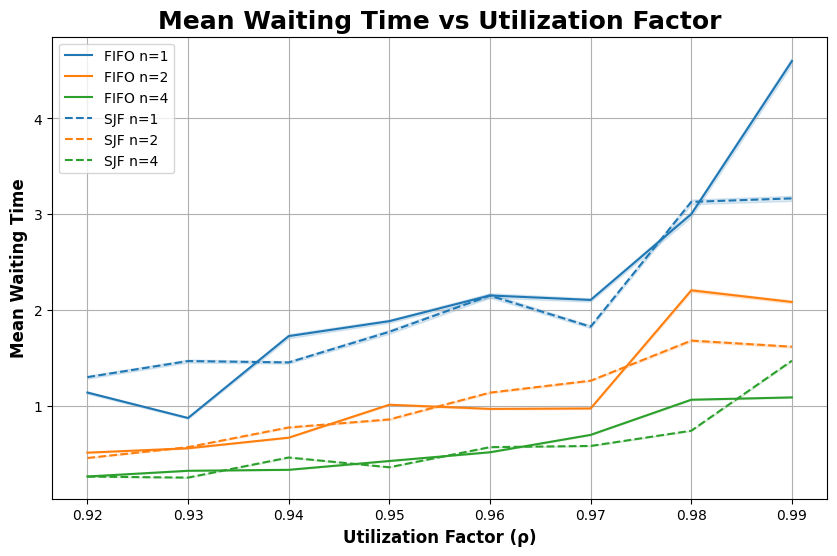

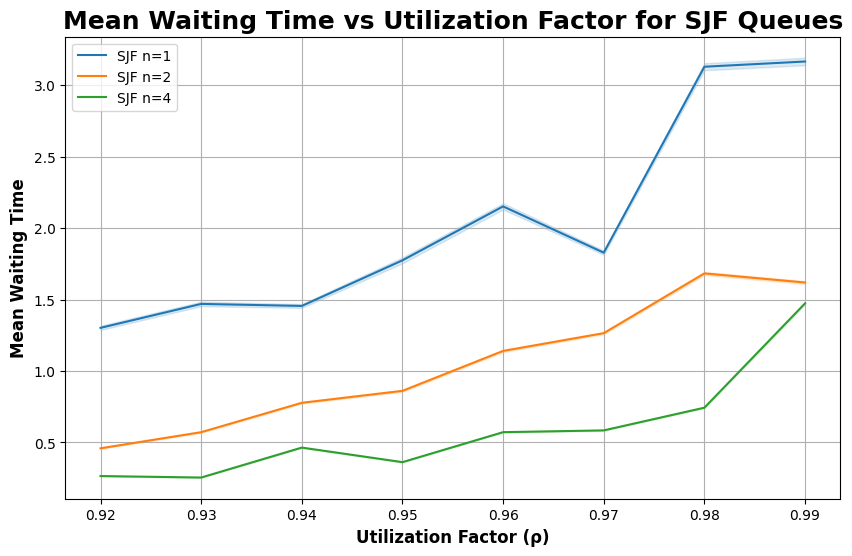

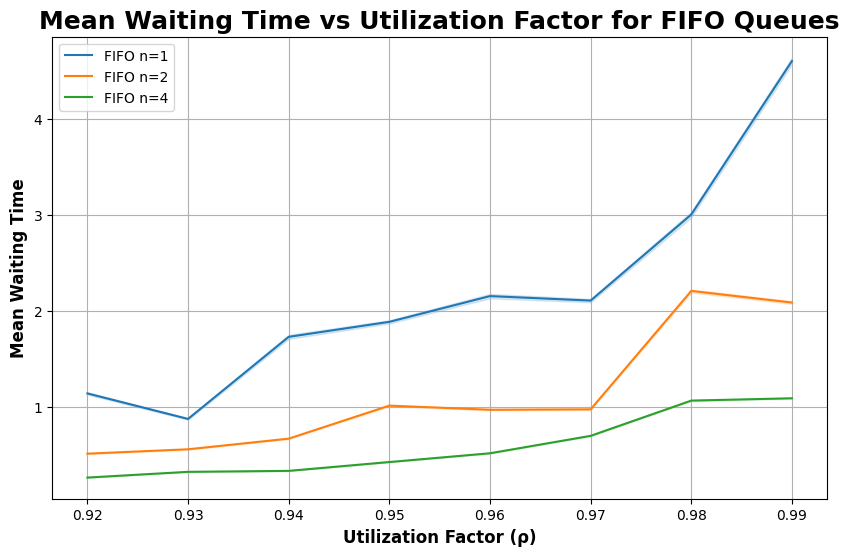

In [2]:

# Running FIFO and SJF simulations
results_fifo = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="M")
results_sjf = main(NUM_SERVERS, RHO_VALUES, priority=True, service_type="M")


# Plotting FIFO and SJF results together
plot_results([results_fifo, results_sjf], "Mean Waiting Time vs Utilization Factor", ["FIFO", "SJF"])

# Plotting SJF
plot_results([results_sjf], "Mean Waiting Time vs Utilization Factor for SJF Queues", ["SJF"])

# Plotting FIFO
plot_results([results_fifo], "Mean Waiting Time vs Utilization Factor for FIFO Queues", ["FIFO"])


Number of servers: 1, ρ: 0.92, Mean wait time: 0.56, 95% CI: (0.56, 0.57), Mean sojourn time: 0.66, 95% CI: (0.66, 0.67)
Number of servers: 1, ρ: 0.93, Mean wait time: 0.69, 95% CI: (0.68, 0.69), Mean sojourn time: 0.79, 95% CI: (0.78, 0.79)
Number of servers: 1, ρ: 0.9400000000000001, Mean wait time: 0.80, 95% CI: (0.79, 0.81), Mean sojourn time: 0.90, 95% CI: (0.89, 0.91)
Number of servers: 1, ρ: 0.9500000000000001, Mean wait time: 0.97, 95% CI: (0.97, 0.98), Mean sojourn time: 1.07, 95% CI: (1.07, 1.08)
Number of servers: 1, ρ: 0.96, Mean wait time: 1.15, 95% CI: (1.14, 1.16), Mean sojourn time: 1.25, 95% CI: (1.24, 1.26)
Number of servers: 1, ρ: 0.97, Mean wait time: 1.35, 95% CI: (1.33, 1.36), Mean sojourn time: 1.45, 95% CI: (1.43, 1.46)
Number of servers: 1, ρ: 0.98, Mean wait time: 1.56, 95% CI: (1.54, 1.57), Mean sojourn time: 1.66, 95% CI: (1.64, 1.67)
Number of servers: 1, ρ: 0.99, Mean wait time: 2.51, 95% CI: (2.49, 2.53), Mean sojourn time: 2.61, 95% CI: (2.59, 2.63)
Numb

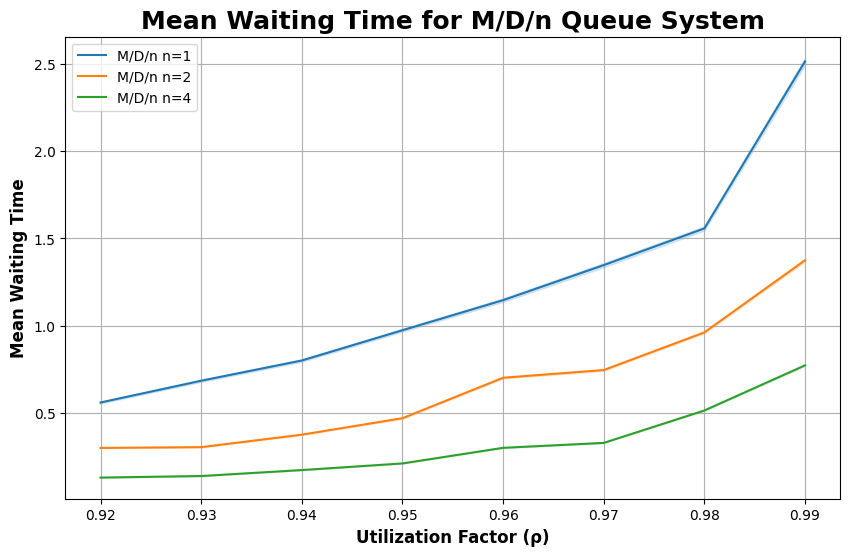

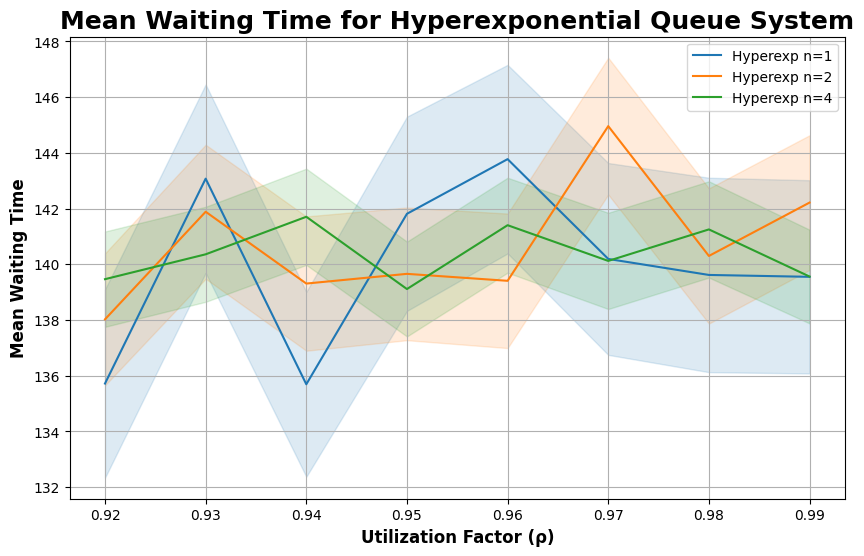

In [3]:

# Running simulations for different service rate distributions
results_mdn = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="D")
results_hyper = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="H")

# Plotting results for different service rate distributions
plot_results([results_mdn], "Mean Waiting Time for M/D/n Queue System", ["M/D/n"])
plot_results([results_hyper], "Mean Waiting Time for Hyperexponential Queue System", ["Hyperexp"])


Number of servers: 1, ρ: 0.92, Mean wait time: 1.22, 95% CI: (1.20, 1.23), Mean sojourn time: 1.32, 95% CI: (1.30, 1.33)
Number of servers: 1, ρ: 0.93, Mean wait time: 1.38, 95% CI: (1.37, 1.39), Mean sojourn time: 1.48, 95% CI: (1.47, 1.49)
Number of servers: 1, ρ: 0.9400000000000001, Mean wait time: 1.33, 95% CI: (1.32, 1.35), Mean sojourn time: 1.43, 95% CI: (1.42, 1.45)
Number of servers: 1, ρ: 0.9500000000000001, Mean wait time: 1.66, 95% CI: (1.64, 1.67), Mean sojourn time: 1.76, 95% CI: (1.74, 1.77)
Number of servers: 1, ρ: 0.96, Mean wait time: 2.03, 95% CI: (2.01, 2.05), Mean sojourn time: 2.13, 95% CI: (2.11, 2.15)
Number of servers: 1, ρ: 0.97, Mean wait time: 2.30, 95% CI: (2.28, 2.32), Mean sojourn time: 2.40, 95% CI: (2.38, 2.42)
Number of servers: 1, ρ: 0.98, Mean wait time: 2.57, 95% CI: (2.54, 2.59), Mean sojourn time: 2.67, 95% CI: (2.64, 2.69)
Number of servers: 1, ρ: 0.99, Mean wait time: 3.46, 95% CI: (3.44, 3.49), Mean sojourn time: 3.56, 95% CI: (3.54, 3.59)
Numb

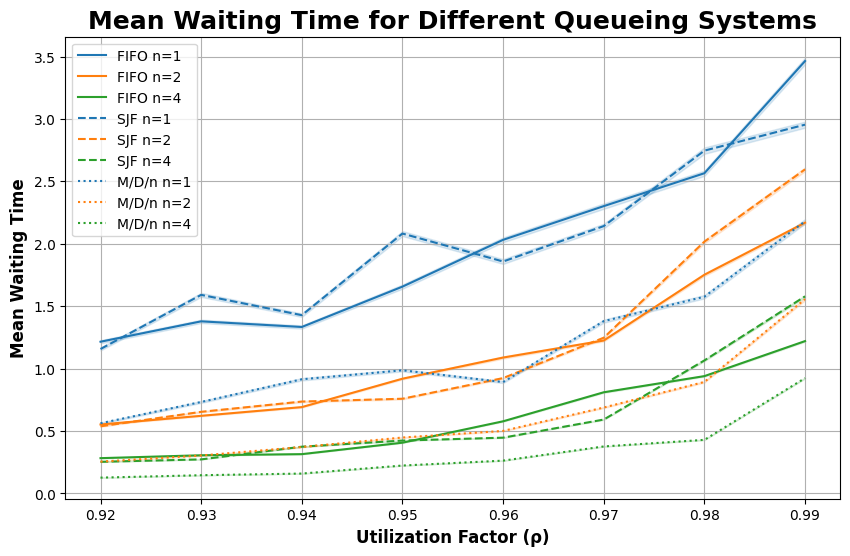

In [4]:
results_fifo = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="M")
results_sjf = main(NUM_SERVERS, RHO_VALUES, priority=True, service_type="M")
results_mdn = main(NUM_SERVERS, RHO_VALUES, priority=False, service_type="D")

# Plotting results for different queueing systems
plot_results([results_fifo, results_sjf, results_mdn], "Mean Waiting Time for Different Queueing Systems", ["FIFO", "SJF", "M/D/n"])

In [5]:
from scipy import stats

fifo_n1_waiting_times = [waiting_time for n, _, waiting_time, _, _, _, _, _ in results_fifo if n == 1]
sjf_n1_waiting_times = [waiting_time for n, _, waiting_time, _, _, _, _, _ in results_sjf if n == 1]
mdn_n1_waiting_times = [waiting_time for n, _, waiting_time, _, _, _, _, _ in results_mdn if n == 1]

# Perform t-test
t_stat, p_value = stats.ttest_ind(fifo_n1_waiting_times, mdn_n1_waiting_times)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("The difference in mean waiting times between FIFO and SJF for n=1 is statistically significant.")
else:
    print("No significant difference in mean waiting times between FIFO and SJF for n=1 was found.")

T-statistic: 2.549670507913042, P-value: 0.02313216873228121
The difference in mean waiting times between FIFO and SJF for n=1 is statistically significant.
